---
* ### Import as libs  
---

In [49]:
import sympy as sp
import numpy as np
import matplotlib.pyplot as plt
import control as ctl
from carima import generate_matrices, get_G, get_F
from matplotlib.ticker import AutoMinorLocator, FormatStrFormatter, MaxNLocator
from matplotlib.animation import FuncAnimation, PillowWriter

---
* ### Função para plotar, printar TF e matriz
---

In [50]:
def plot(time, y_matriz, title, cols_name, time_aux=None, y_matriz_aux=None, plot=False, yticks_min0max=False, xticks_min0max=False):
    """
    Plota gráficos em grade (n_row x n_col) com estilo mais profissional,
    preservando 100% a lógica original de offsets, step/plot e legendas.
    """
    n_row, n_col = len(y_matriz), len(y_matriz[0])

    # altura = 1 * n_row
    altura = n_row * 1.12

    with plt.rc_context({
        "font.size": 9,
        "axes.titlesize": 10,
        "axes.labelsize": 9,
        "legend.fontsize": 8,
        "xtick.labelsize": 8,
        "ytick.labelsize": 8,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "figure.constrained_layout.use": False
    }):
        fig, axs = plt.subplots(n_row, n_col, figsize=(11, altura), sharex=True, constrained_layout=True)

        if n_row == 1 and n_col == 1:
            axs = [[axs]]
        elif n_row == 1:
            axs = [axs]
        elif n_col == 1:
            axs = [[ax] for ax in axs]

        for j in range(n_col):
            axs[0][j].set_title(f'{title} - {cols_name[j]}')

        main_lw = 1.1
        aux_lw = 1.0
        msize = 3

        for i in range(n_row):
            for j in range(n_col):
                ax = axs[i][j]
                ax.set_axisbelow(True)  
                ax.grid(True, which='major', linestyle=':', alpha=0.5)
                ax.xaxis.set_minor_locator(AutoMinorLocator())
                ax.yaxis.set_minor_locator(AutoMinorLocator())
                ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
                ax.margins(y=0.1) 
                ax.yaxis.set_major_formatter(FormatStrFormatter('%.1f'))
                ax.yaxis.set_major_locator(MaxNLocator(nbins='auto', prune=None))
                #ymin, ymax = ax.get_ylim()
                #x.set_ylim(ymin, ymax)

                for side in ["top", "right", "left", "bottom"]:
                    ax.spines[side].set_linewidth(0.8)
                    ax.spines[side].set_alpha(0.6)

                offset_x = 0
                if y_matriz_aux is not None and time_aux is not None:
                    dic_aux = y_matriz_aux[i][j]
                    offset_x = len(dic_aux[0])
                    if plot:
                        ax.plot(
                            time_aux[:offset_x], dic_aux[0],
                            label=dic_aux[1], color=dic_aux[2], marker=dic_aux[3],
                            linewidth=aux_lw, markersize=msize, alpha=0.95
                        )
                    else:
                        ax.step(
                            time_aux[:offset_x], dic_aux[0],
                            label=dic_aux[1], color=dic_aux[2], marker=dic_aux[3],
                            linewidth=aux_lw, where='pre'
                        )

                    # transforma em dt
                    dt = time[1] - time[0]
                    offset_x = offset_x * dt

                # plota as linhas principais
                dic = y_matriz[i][j]
                if plot:
                    ax.plot(
                        time + offset_x, dic[0],
                        label=dic[1], color=dic[2], marker=dic[3],
                        linewidth=main_lw, markersize=msize, alpha=0.98
                    )
                else:
                    ax.step(
                        time + offset_x, dic[0],
                        label=dic[1], color=dic[2], marker=dic[3],
                        linewidth=main_lw, where='pre'
                    )

                leg = ax.legend(loc='upper right', frameon=True, framealpha=0.85,
                                handlelength=1.8, borderaxespad=0.6)
                leg.get_frame().set_linewidth(0.6)
                leg.get_frame().set_alpha(0.9)

        plt.tight_layout(pad=1.2)
        plt.show()

def print_tf(sys):
    # printa só as ultimas 3 linhas 
    text = sys.__str__().splitlines()
    for line in text[-3:]:
        print(line)

# Converter cada canal SymPy -> control.TransferFunction SISO (em s)
def sympy_to_tf(expr_s, s_symbol):
    """Converte uma função racional em s (SymPy) -> control.TransferFunction SISO."""
    num, den = sp.fraction(sp.together(sp.simplify(expr_s)))
    num_poly = sp.Poly(num, s_symbol)
    den_poly = sp.Poly(den, s_symbol)

    # Coeficientes do maior para o menor grau
    num_cf = [float(c) for c in num_poly.all_coeffs()]
    den_cf = [float(c) for c in den_poly.all_coeffs()]
    return ctl.tf(num_cf, den_cf)

def print_matriz(mat):
    sp.pprint(mat)
    print()

In [51]:
def plot_ladder_uq(time, y_matriz, cols_name=("u","q"),
                   title=("Resposta - U","Resposta - Q"),
                   x_label="Deslocamento",
                   make_gif=False, gif_path="ladder_uq.gif",
                   fps=15, stride=1):
    # --- validação / shape ---
    if not isinstance(y_matriz, (list, tuple)) or len(y_matriz) == 0:
        raise ValueError("y_matriz inválido/vazio.")
    n_row = len(y_matriz)
    n_col = len(y_matriz[0])
    if n_col < 2:
        raise ValueError("y_matriz deve ter pelo menos 2 colunas (U e Q).")

    def extract_col(j):
        series = []
        for i in range(n_row):
            dic = y_matriz[i][j]
            y = np.asarray(dic[0])
            label = str(dic[1]) if len(dic) > 1 else f"S{i}"
            color = dic[2] if len(dic) > 2 else None
            marker = dic[3] if len(dic) > 3 else 'o'
            series.append((y, label, color, marker))
        return series

    series_U = extract_col(0)
    series_Q = extract_col(1)
    T = len(np.asarray(time))
    y_pos = np.arange(1, n_row + 1)

    # Xmax global (para X simétrico)
    def max_abs(series):
        return max(float(np.max(np.abs(s[0]))) for s in series)
    Xmax = max(max_abs(series_U), max_abs(series_Q))
    Xpad = 1.08 * (Xmax if Xmax > 0 else 1.0)

    with plt.rc_context({
        "font.size": 9,
        "axes.titlesize": 11,
        "axes.labelsize": 10,
        "legend.fontsize": 8,
        "xtick.labelsize": 9,
        "ytick.labelsize": 9,
        "axes.linewidth": 0.8,
        "grid.linewidth": 0.6,
        "axes.autolimit_mode": "round_numbers",
    }):
        fig, axs = plt.subplots(1, 2, figsize=(8.2, 4.8), constrained_layout=True, sharey=True)

        def setup_axis(ax, ttl):
            ax.set_axisbelow(True)
            ax.grid(True, which='major', linestyle=':', alpha=0.5)
            ax.xaxis.set_minor_locator(AutoMinorLocator())
            ax.yaxis.set_minor_locator(AutoMinorLocator())
            ax.grid(True, which='minor', linestyle=':', alpha=0.3, linewidth=0.5)
            ax.yaxis.set_major_locator(MaxNLocator(integer=True))
            ax.yaxis.set_major_formatter(FormatStrFormatter('%.0f'))
            ax.xaxis.set_major_formatter(FormatStrFormatter('%.2f'))
            ax.set_ylim(y_pos[0] - 0.5, y_pos[-1] + 0.5)
            ax.set_xlim(-Xpad, Xpad)     # <<-- simétrico
            ax.set_title(ttl)
            ax.set_xlabel(x_label)

        setup_axis(axs[0], f"{title[0]}")
        setup_axis(axs[1], f"{title[1]}")
        axs[0].set_yticks(y_pos, [s[1] for s in series_U])
        axs[0].set_ylabel("")

        def draw_column(ax, series):
            # referência de máximos positivos (como pedido originalmente)
            x_max = np.array([float(np.max(s[0])) for s in series])
            (curve_ref,) = ax.plot(x_max, y_pos, linewidth=1.2, alpha=0.9, color='k')
            max_handles = []
            for i, (y, label, color, marker) in enumerate(series):
                hmax = ax.plot([x_max[i]], [y_pos[i]],
                               linestyle='None',
                               marker=marker or 'o',
                               markersize=7.5,
                               markerfacecolor='none',
                               markeredgewidth=1.2,
                               color='0.5')[0]
                max_handles.append(hmax)
            # pontos dinâmicos (valor instantâneo)
            x_now = np.array([float(s[0][-1]) for s in series])
            (curve_dyn,) = ax.plot(x_now, y_pos, linewidth=1.2, alpha=0.9, color='k')
            dyn_handles = []
            for i, (y, label, color, marker) in enumerate(series):
                h = ax.plot([x_now[i]], [y_pos[i]],
                            linestyle='None',
                            marker=marker or 'o',
                            markersize=7.5,
                            markerfacecolor='none',
                            markeredgewidth=1.2,
                            color=(color if color is not None else 'k'))[0]
                dyn_handles.append(h)
            return curve_ref, max_handles, curve_dyn, dyn_handles

        refU, maxU, dynU_curve, dynU_pts = draw_column(axs[0], series_U)
        refQ, maxQ, dynQ_curve, dynQ_pts = draw_column(axs[1], series_Q)

        anim = None
        if make_gif:
            frames_idx = np.arange(1, T + 1, stride, dtype=int)

            def update(k):
                # valor instantâneo (deslocamento) — sem mexer no título
                xU = np.array([float(s[0][k-1]) for s in series_U])
                xQ = np.array([float(s[0][k-1]) for s in series_Q])
                dynU_curve.set_data(xU, y_pos)
                dynQ_curve.set_data(xQ, y_pos)
                for i, h in enumerate(dynU_pts):
                    h.set_data([xU[i]], [y_pos[i]])
                for i, h in enumerate(dynQ_pts):
                    h.set_data([xQ[i]], [y_pos[i]])
                return [dynU_curve, *dynU_pts, dynQ_curve, *dynQ_pts]

            anim = FuncAnimation(fig, update, frames=frames_idx, blit=True, interval=1000/fps)
            anim.save(gif_path, writer=PillowWriter(fps=fps))

        plt.show()
        return anim


---
* ### Constantes
---

In [52]:
n_node = 6

# massas
coef_m = 0.5
ATMD_m = 2.5
m_arr = [i*coef_m if i < n_node+1 else ATMD_m for i in range(1, n_node+2)]

# rigidezes (primeiro: opcionalmente, um scale global para acertar Ts)
coef_k = 1.0
ATMD_k = 0.5
k_arr = [i*coef_k if i < n_node+1 else ATMD_k for i in range(1, n_node+2)]

# (opcional) deixar U com metade do ganho DC vs Q sem mexer em b:
# suponha que U é mais sensível a nós {u_idx_list}; dobre k nesses nós:
u_idx_list = [4, 5]        # <<< ajuste para os nós que pesam em U
k_arr = [ (2.0*k if (idx+1) in u_idx_list else k)
          for idx, k in enumerate(k_arr) ]

# recompute c para zeta* alvo (igualando Ts aprox. entre Q e U)
zeta_star = 0.7
import math
c_arr = [ 2.0*zeta_star*math.sqrt(k*m) for k, m in zip(k_arr, m_arr) ]

# participação modal (para simulações separadas de Q e U)
beta_0 = 0.0033
beta_Q = 2.0*beta_0   # dá Q ≈ 2×U via ganho DC
beta_U = 1.0*beta_0


---
* ### Matrizes
---

In [53]:
# ATMD variaveis 
c_and_coef = True
offset = 1 if c_and_coef else 2

# Matriz de massa
m_matriz = sp.diag(*m_arr)

# Matriz de amortecimento
c_arr_desl = [c_arr[i] + c_arr[i+1] if i < len(c_arr) - 1 else c_arr[i] for i in range(len(c_arr))]
c_matriz = sp.diag(*c_arr_desl)
for i in range(len(c_arr) - offset):
    c_matriz[i, i+1] = -c_arr[i+1]
    c_matriz[i+1, i] = -c_arr[i+1]

# Matriz de rigidez
k_arr_desl = [k_arr[i] + k_arr[i+1] if i < len(k_arr) - 1 else k_arr[i] for i in range(len(k_arr))]
k_matriz = sp.diag(*k_arr_desl)
for i in range(len(k_arr) - offset):
    k_matriz[i, i+1] = -k_arr[i+1]
    k_matriz[i+1, i] = -k_arr[i+1]

# Matriz da entrada u [0 0 0 ... -1 1].T 
B = sp.Matrix([[0] for _ in range(n_node - 1)] + [[-1], [1]])

# Matriz da entrada do deslocamento do solo [beta_0*m0 beta_1*0 ... beta_n*mn m_ATMD].T
C = sp.Matrix([[m_arr[0] * beta_0 * i] for i in range(1, n_node+1)] + [[m_arr[-1]]])

---
* ### Funções de transferência
---

In [54]:
t, s = sp.symbols('t s', positive=True, real=True)

# M*x'' + N*x' + K*x = B*u + C*q
# (M*s**2 + N*s + K)*X = B*U + C*Q
# AX = BU + CQ
A = m_matriz*s**2 + c_matriz*s + k_matriz

# Função de transferência do sistema
H_U = (A.inv() * B)
H_Q = (A.inv() * C)

# Simplificação das expressões
H_U = sp.simplify(H_U)
H_Q = sp.simplify(H_Q)

# matriz de transferência do sistema 
H = sp.Matrix.hstack(H_U, H_Q)

---
* ### Matriz de TF - sistema continuo
---

In [55]:
H_s_matriz = [[] for _ in range(H.rows)]
for i in range(H.rows):
    for j in range(H.cols):
        H_s_matriz[i].append(sympy_to_tf(H[i,j], s))

for hi in H_s_matriz:
    for hj in hi:
        print_tf(hj)
        print()

                                                                        -3423 s^7 - 2.015e+04 s^6 - 4.71e+04 s^5 - 5.463e+04 s^4 - 3.146e+04 s^3 - 7200 s^2
  -------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
  28.12 s^14 + 877.7 s^13 + 1.128e+04 s^12 + 7.956e+04 s^11 + 3.481e+05 s^10 + 1.016e+06 s^9 + 2.067e+06 s^8 + 2.995e+06 s^7 + 3.112e+06 s^6 + 2.292e+06 s^5 + 1.166e+06 s^4 + 3.947e+05 s^3 + 8.603e+04 s^2 + 1.223e+04 s + 1440

                             0.09281 s^12 + 2.713 s^11 + 32.41 s^10 + 211.4 s^9 + 853.8 s^8 + 2299 s^7 + 9649 s^6 + 3.89e+04 s^5 + 8.901e+04 s^4 + 1.124e+05 s^3 + 7.799e+04 s^2 + 2.738e+04 s + 3650
  -----------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

---
* ### Matriz de TF - sistema discreto
---

In [56]:
# tempo de amostragem 
T = 1.75

H_z_matriz = [[] for _ in range(H.rows)]

# converter cada canal para TF discreto
for i in range(H.rows):
    for j in range(H.cols):
        H_z_matriz[i].append(ctl.sample_system(H_s_matriz[i][j], T, method="zoh"))

# print
for hi in H_z_matriz:
    for hj in hi:
        print_tf(hj)
        print()

  -0.01682 z^13 - 0.04201 z^12 + 0.1536 z^11 - 0.1061 z^10 + 0.0003981 z^9 + 0.01456 z^8 - 0.003965 z^7 + 0.0003677 z^6 - 1.054e-06 z^5 - 1.568e-06 z^4 + 5.746e-08 z^3 + 2.424e-10 z^2 + 1.322e-14 z + 5.543e-21
  ---------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------
   z^14 - 2.838 z^13 + 3.276 z^12 - 1.971 z^11 + 0.7253 z^10 - 0.1877 z^9 + 0.04334 z^8 - 0.006948 z^7 + 0.0006285 z^6 - 3.25e-05 z^5 + 1.152e-06 z^4 - 2.534e-08 z^3 + 8.752e-12 z^2 - 2.669e-17 z + 1.917e-24

  0.01313 z^13 + 0.1711 z^12 + 0.02949 z^11 - 0.158 z^10 + 0.0523 z^9 + 0.0005337 z^8 - 0.002484 z^7 + 0.0003751 z^6 - 1.586e-05 z^5 - 4.336e-07 z^4 + 3.273e-08 z^3 + 7.715e-11 z^2 + 2.666e-15 z + 8.592e-22
  ------------------------------------------------------------------------------------------------------------------------------------------------------------------

---
* ### Plot - resposta ao impulso
---

In [57]:
# dados pra simular
start = 0
stop = 150
step = T
step_continuo = 0.01
time = np.arange(start, stop, step)
time_continuo = np.arange(start, stop, step_continuo)

cols_name = ['u', 'q']

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_37380\896539443.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


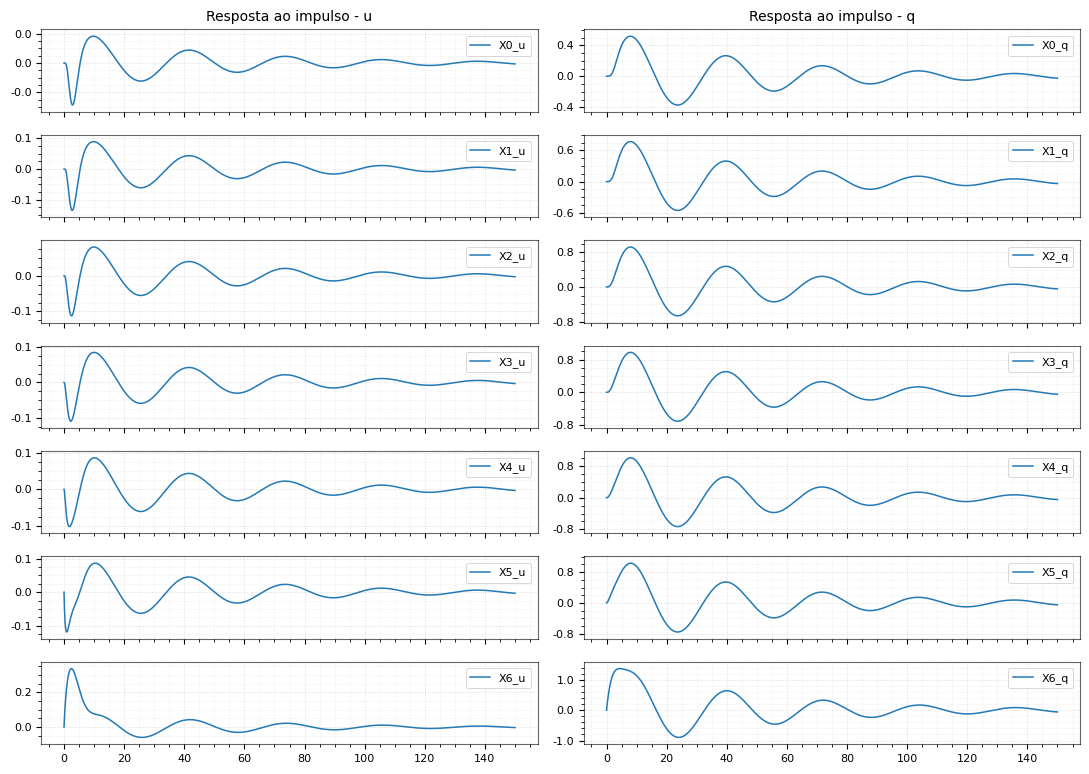

In [58]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_s_matriz[i][j], T=time_continuo)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time_continuo, y_matriz_out, "Resposta ao impulso", cols_name, plot=True)

---
* ### Plot - resposta ao impulso
---

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_37380\896539443.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


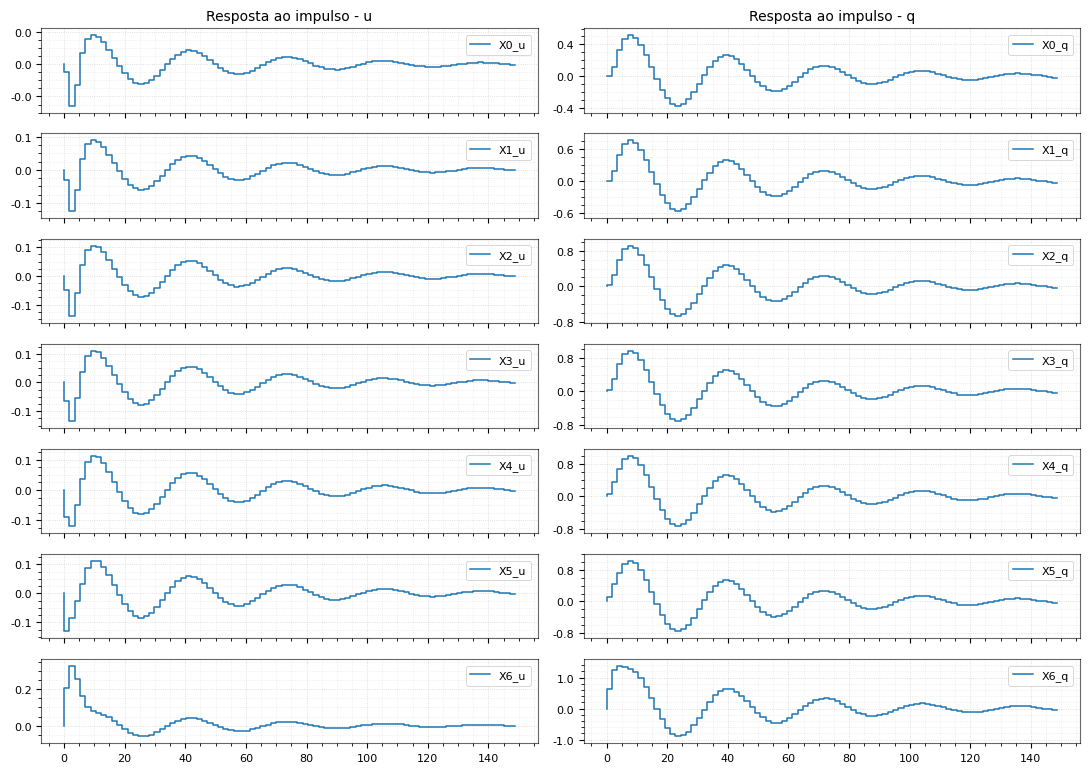

In [59]:
# plot a resposta ao impulso
y_matriz_out = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        t_out, y_out = ctl.impulse_response(H_z_matriz[i][j], T=time)
        y_plot = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_matriz_out[i].append(y_plot)

# plot 
plot(time, y_matriz_out, "Resposta ao impulso", cols_name)

---
* ### Predição - usando CARIMA
---

C:\Users\alison.tristao\AppData\Local\Temp\ipykernel_37380\896539443.py:97: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.2)


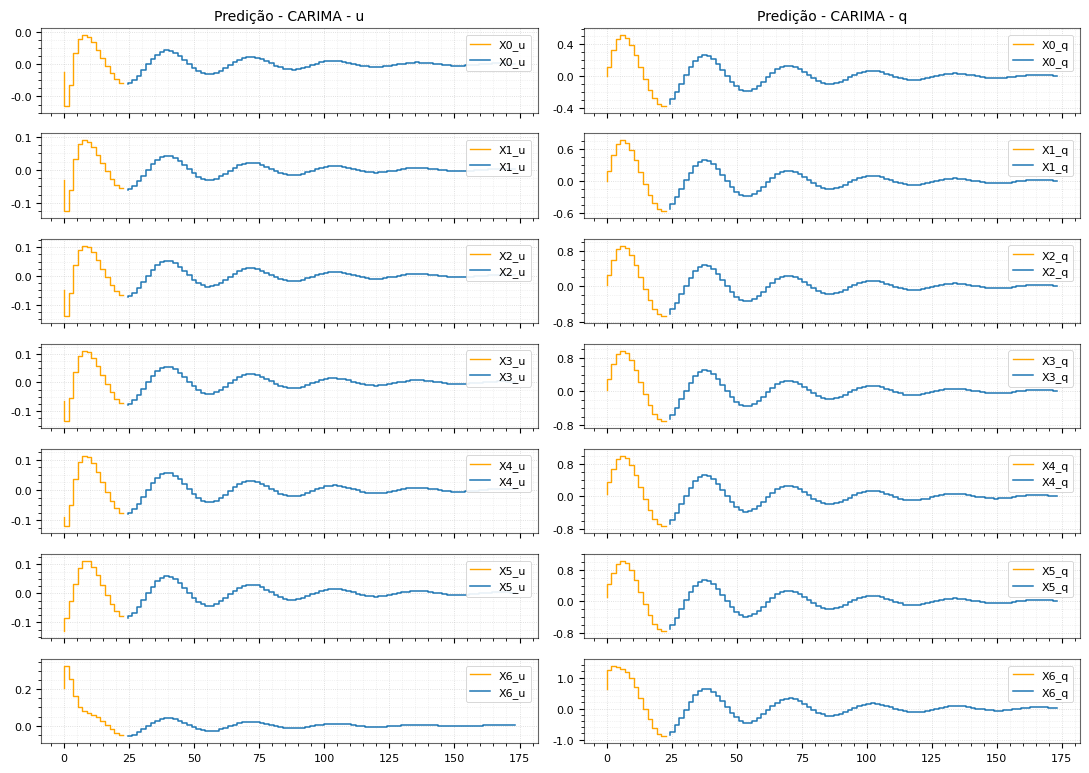

In [60]:
y_pred = [[] for _ in range(H.rows)]
y_pass = [[] for _ in range(H.rows)]

for i in range(H.rows):
    for j in range(H.cols):
        F = get_F(H_z_matriz[i][j], len(time))
        # pegar a condição inicial 
        y_in = y_matriz_out[i][j][0][1:F.shape[1]+1][::-1]

        # calcula a resposta livre
        y_out = F @ y_in

        # salva pra plotar
        y_plot0 = [y_out.tolist(), "X{}_{}".format(i, cols_name[j]), 'C0', None]
        y_plot1 = [y_in[::-1], "X{}_{}".format(i, cols_name[j]), 'orange', None]
        y_pred[i].append(y_plot0)
        y_pass[i].append(y_plot1)

# plot 
plot(time, y_pred, "Predição - CARIMA", cols_name, time_aux=time, y_matriz_aux=y_pass)

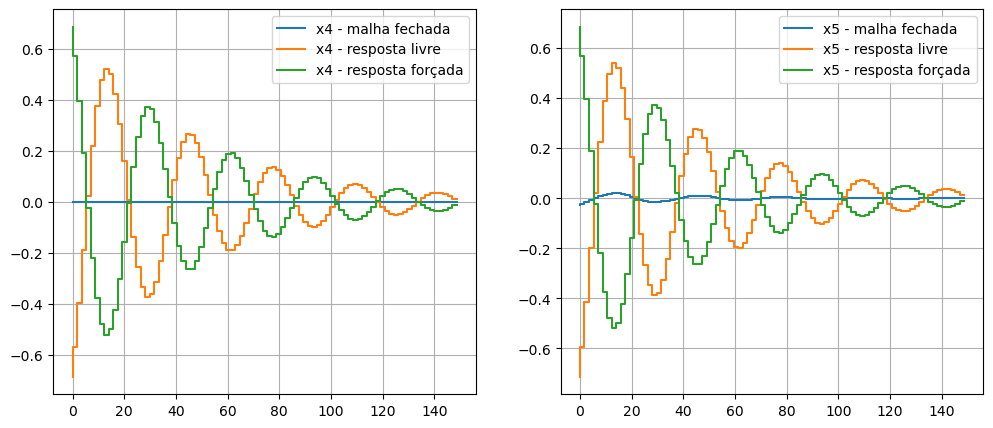

In [61]:
# ponderação nas ações de controle
alpha = 0.0
N_y = len(time)
N_u = len(time)

R = np.eye(N_u) * alpha
Q = np.eye(N_u) # monovariavel - delta é fixo = 1

F, G = generate_matrices(H_z_matriz[n_node-1][0], N_u, N_y)

# solution of quadratic problem
K = np.linalg.inv(G.T @ G + R) @ G.T

# solucao do sistema (free para a massa da nacele)
x0_free = y_pred[n_node-2][1][0]
u_opt = -K @ x0_free

# calcula a resposta forçada
x0_forced = G @ u_opt

# resposta total 
x0 = x0_free + x0_forced

x1_free = y_pred[n_node-1][1][0]
x1_forced = G @ u_opt
x1 = x1_free + x1_forced

# plot 
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

ax[0].step(time, x0, label='x{} - malha fechada'.format(n_node-2))
ax[0].step(time, x0_free, label='x{} - resposta livre'.format(n_node-2))
ax[0].step(time, x0_forced, label='x{} - resposta forçada'.format(n_node-2))

ax[1].step(time, x1, label='x{} - malha fechada'.format(n_node-1))
ax[1].step(time, x1_free, label='x{} - resposta livre'.format(n_node-1))
ax[1].step(time, x1_forced, label='x{} - resposta forçada'.format(n_node-1))

for a in ax:
    a.grid()
    a.legend()
plt.show()


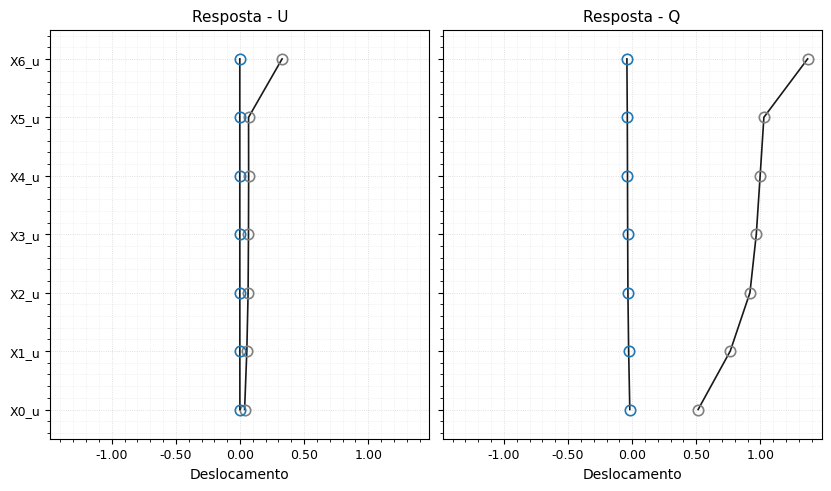

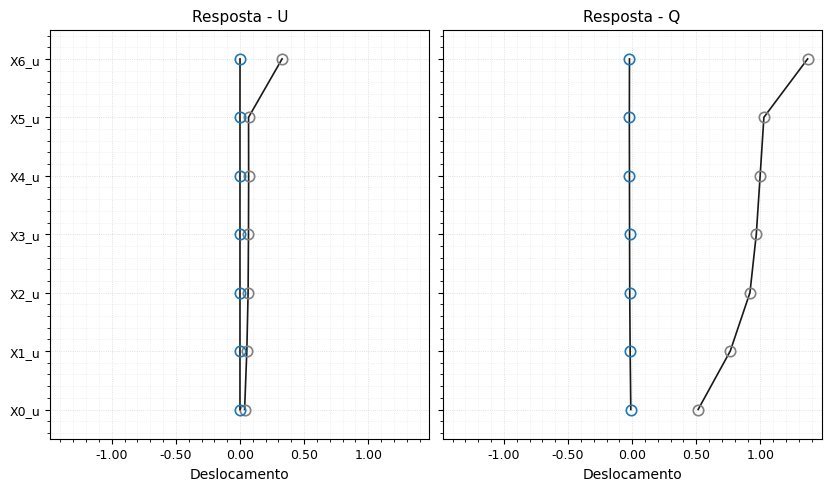

In [62]:
# supondo que você já tenha time e y_matriz no seu formato padrão:
# cada item: [dados_numpy, "X0_u", "tab:blue", "o"]

# 1) Só o “ladder” de máximos estático
plot_ladder_uq(time, y_matriz_out)

# 2) Com GIF do máximo acumulado ao longo do tempo
plot_ladder_uq(time, y_matriz_out,
                make_gif=True, gif_path="max_ladder.gif", fps=15, stride=2)
# arquivo será salvo como max_ladder.gif na pasta atual